### **Installing Necessary Libraries**

In [441]:
import numpy as np
import pandas as pd
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score, classification_report, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import label_binarize

### **Data Loading and Preprocessing**

In [369]:
# Örnek: veriyi okuma
df = pd.read_excel("Tweets.xlsx")

df = df[df["Target"] != "Donald Trump"]

# Kolon isimlerinin aynen kaldığını varsayıyoruz:
# ["Tweet", "Target", "Train/Test", "Stance", "Opinion Toward", "Sentiment labels"]

def basic_preprocessing(text):
    # Küçük harfe çevir
    text = text.lower()
    # @ ile başlayan kelimeleri temizle
    text = re.sub(r'@\w+', '', text)
    # Özel karakterleri temizle, sadece harf, rakam, boşluk, '-', '_', ve '#' karakterlerini bırak
    text = re.sub(r"[^\w\s#_-]+", " ", text)
    # Fazla boşlukları sil
    text = re.sub(r"\s+", " ", text)
    text = text.strip()  # Boşlukları (trim) temizle
    return text

df["Preprocessed_Tweet"] = df["Tweet"].apply(basic_preprocessing)





### **Editing Category (Target) Classes and Stance (FAVOR / AGAINST / NEITHER) Classes**

In [370]:
# Target için LabelEncoder
le_target = LabelEncoder()
df["Target_label"] = le_target.fit_transform(df["Target"])
num_classes_target = len(df["Target_label"].unique())

# Stance için LabelEncoder
le_stance = LabelEncoder()
df["Stance_label"] = le_stance.fit_transform(df["Stance"])
num_classes_stance = len(df["Stance_label"].unique())

### **Training/Validation Spliting**

In [371]:
df_train = df[df["Train/Test"] == "Train"].copy()
df_test  = df[df["Train/Test"] == "Test"].copy()

X_train_text = df_train["Preprocessed_Tweet"].values
y_train_target = df_train["Target_label"].values
y_train_stance = df_train["Stance_label"].values

X_test_text = df_test["Preprocessed_Tweet"].values
y_test_target = df_test["Target_label"].values
y_test_stance = df_test["Stance_label"].values


X_tr_text, X_val_text, y_tr_target, y_val_target = train_test_split(
    X_train_text, y_train_target, test_size=0.2, random_state=42
)

X_tr_text_s, X_val_text_s, y_tr_stance, y_val_stance = train_test_split(
    X_train_text, y_train_stance, test_size=0.2, random_state=42
)

### **Tokenize and Sequence Texts**

In [372]:
MAX_VOCAB_SIZE = 10000   # Sözlük boyutu (isteğe göre artırılabilir)
MAX_SEQ_LEN = 30         # Maksimum token sayısı

tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train["Preprocessed_Tweet"])

def text_to_seq(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')
    return padded

X_tr_seq = text_to_seq(X_tr_text)
X_val_seq = text_to_seq(X_val_text)
X_test_seq = text_to_seq(X_test_text)

### **Model–1: Target Classification - Model Architecture**

In [373]:
model_target = keras.models.Sequential([
    layers.Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=128, 
                     input_length=MAX_SEQ_LEN),
    layers.LSTM(128, return_sequences=False),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes_target, activation='softmax')
])

model_target.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

C:\Users\telat\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### **Traninig**

In [374]:
epochs = 20
batch_size = 32

history_target = model_target.fit(
    X_tr_seq, y_tr_target,
    validation_data=(X_val_seq, y_val_target),
    epochs=20,
    batch_size=batch_size
)



Epoch 1/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.2388 - loss: 1.5902 - val_accuracy: 0.3499 - val_loss: 1.4151
Epoch 2/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4021 - loss: 1.2883 - val_accuracy: 0.3739 - val_loss: 1.3121
Epoch 3/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.4631 - loss: 1.0535 - val_accuracy: 0.3962 - val_loss: 1.3513
Epoch 4/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5335 - loss: 0.9067 - val_accuracy: 0.4734 - val_loss: 1.5173
Epoch 5/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7359 - loss: 0.6239 - val_accuracy: 0.6158 - val_loss: 1.1487
Epoch 6/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8479 - loss: 0.4096 - val_accuracy: 0.6261 - val_loss: 1.2779
Epoch 7/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9472 - loss: 0.1675 - val_accuracy: 0.6312 - val_loss: 1.4932
Epoch 8/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9533 - loss: 0.1544 - val_accuracy: 0.6432 - v

### **Evaluation (Target)**

In [375]:
# Validation set üzerinde
val_preds_target = model_target.predict(X_val_seq).argmax(axis=1)
print("F1 Score (Target classification) [Val]:", f1_score(y_val_target, val_preds_target, average="weighted"))
print(classification_report(y_val_target, val_preds_target))

# Test set üzerinde
X_test_seq = text_to_seq(X_test_text)  # test verisine de preprocess
test_preds_target = model_target.predict(X_test_seq).argmax(axis=1)
print("F1 Score (Target classification) [Test]:", 
      f1_score(y_test_target, test_preds_target, average="weighted"))

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
F1 Score (Target classification) [Val]: 0.6386058096606255
              precision    recall  f1-score   support

           0       0.62      0.68      0.65       117
           1       0.63      0.49      0.55        79
           2       0.61      0.72      0.66       135
           3       0.74      0.62      0.68       125
           4       0.63      0.62      0.62       127

    accuracy                           0.64       583
   macro avg       0.64      0.63      0.63       583
weighted avg       0.64      0.64      0.64       583

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
F1 Score (Target classification) [Test]: 0.6338116733972252


In [446]:
test_preds_target = model_target.predict(X_test_seq).argmax(axis=1)
print("Macro Precision [Test]:", precision_score(y_test_target, test_preds_target, average="macro"))
print("Macro Recall [Test]:", recall_score(y_test_target, test_preds_target, average="macro"))

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Macro Precision [Test]: 0.6553412555822804
Macro Recall [Test]: 0.6424338673974986


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


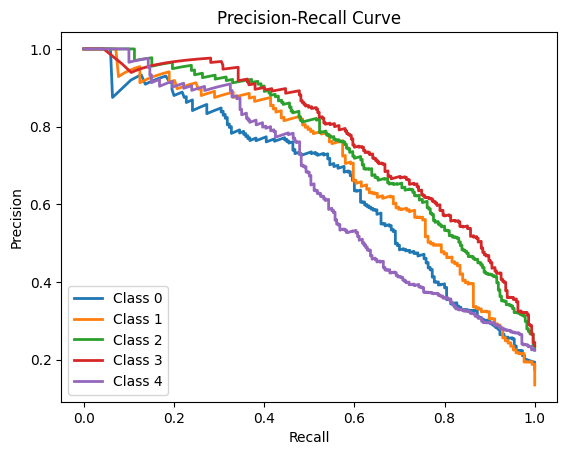

In [444]:
# 3. Precision-Recall Curve
y_test_bin = label_binarize(y_test_target, classes=np.unique(y_test_target))
n_classes = y_test_bin.shape[1]

# Predict probabilities for test set
y_score = model_target.predict(X_test_seq)

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {i}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.show()

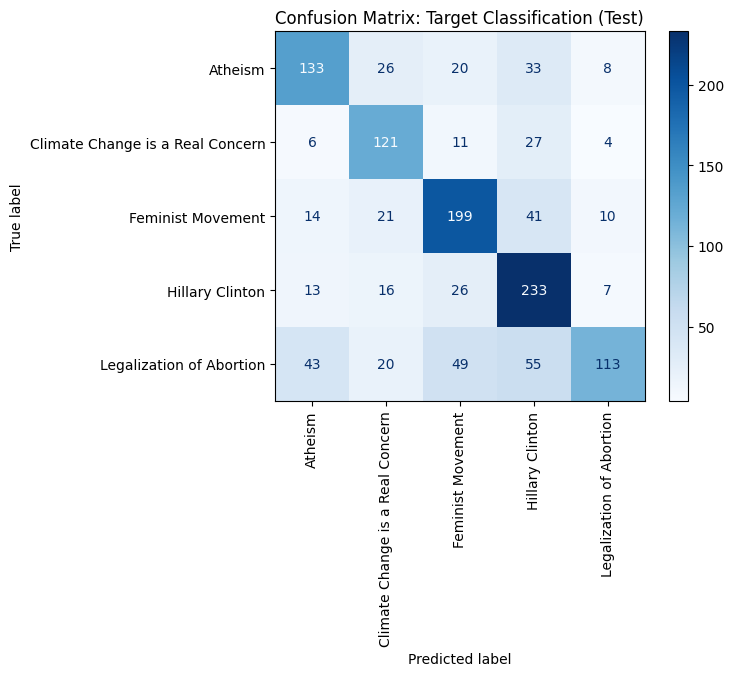

In [447]:
# Confusion matrix for target classification on test set
test_conf_matrix = confusion_matrix(y_test_target, test_preds_target)
test_disp = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=le_target.classes_)
test_disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Target Classification (Test)")
plt.xticks(rotation=90)
plt.show()

Naive Bayes F1 Score: 0.20119301424864247
Naive Bayes Macro Precision: 0.2231450442526493
Naive Bayes Macro Recall: 0.22740569627312235
              precision    recall  f1-score   support

           0       0.22      0.18      0.20       220
           1       0.16      0.45      0.24       169
           2       0.25      0.09      0.14       285
           3       0.27      0.25      0.26       295
           4       0.22      0.17      0.19       280

    accuracy                           0.21      1249
   macro avg       0.22      0.23      0.20      1249
weighted avg       0.23      0.21      0.20      1249



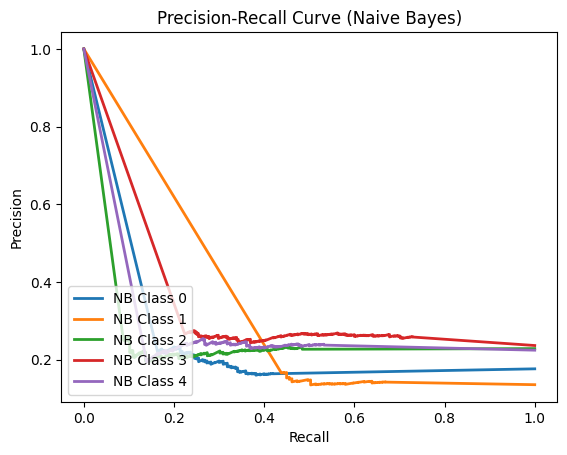

In [445]:
# 4. Naive Bayes Classifier
nb_model = MultinomialNB()
nb_model.fit(X_val_seq, y_val_target)

# Evaluate on test data
nb_preds = nb_model.predict(X_test_seq)
print("Naive Bayes F1 Score:", f1_score(y_test_target, nb_preds, average="weighted"))
print("Naive Bayes Macro Precision:", precision_score(y_test_target, nb_preds, average="macro"))
print("Naive Bayes Macro Recall:", recall_score(y_test_target, nb_preds, average="macro"))
print(classification_report(y_test_target, nb_preds))

# 5. Precision-Recall Curve for Naive Bayes
nb_probs = nb_model.predict_proba(X_test_seq)

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], nb_probs[:, i])
    plt.plot(recall, precision, lw=2, label=f'NB Class {i}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Naive Bayes)")
plt.legend(loc="lower left")
plt.show()

### **Model 2 - Stance Classification - Model Input: Tweet Text + Target Information**

In [376]:
# Train aşamasında ground-truth target label kullanıyoruz
target_onehot_train = to_categorical(y_tr_target, num_classes_target)
target_onehot_val   = to_categorical(y_val_target, num_classes_target)

# Tweet metni embed’ine ek veri olarak one-hot vektörü eklemek için
# Keras’ta bir “functional API” model kuralım:
tweet_input = layers.Input(shape=(MAX_SEQ_LEN,), name="tweet_input")
target_input = layers.Input(shape=(num_classes_target,), name="target_input")

# Tweet embeding + RNN
embedding_layer = layers.Embedding(input_dim=MAX_VOCAB_SIZE, 
                                   output_dim=128, 
                                   input_length=MAX_SEQ_LEN)(tweet_input)
lstm_layer = layers.LSTM(128, return_sequences=False)(embedding_layer)

# RNN çıktısıyla target one-hot’u birleştir
concat = layers.concatenate([lstm_layer, target_input])

dense = layers.Dense(64, activation='relu')(concat)
output = layers.Dense(num_classes_stance, activation='softmax')(dense)

model_stance = keras.Model(inputs=[tweet_input, target_input], outputs=output)

model_stance.compile(
    loss='sparse_categorical_crossentropy',
    optimizer= tf.keras.optimizers.Adam(0.008),
    metrics=['accuracy']
)


C:\Users\telat\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


### **Model Traning**

In [377]:
history_stance = model_stance.fit(
    [X_tr_seq, target_onehot_train],  # Girdi
    y_tr_stance,                      # Çıktı stance label
    validation_data=([X_val_seq, target_onehot_val], y_val_stance),
    epochs=8,
    batch_size=batch_size
)

Epoch 1/8
73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.4826 - loss: 1.0474 - val_accuracy: 0.5455 - val_loss: 0.9813
Epoch 2/8
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5460 - loss: 0.9677 - val_accuracy: 0.5043 - val_loss: 0.9542
Epoch 3/8
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6550 - loss: 0.7690 - val_accuracy: 0.5472 - val_loss: 1.0700
Epoch 4/8
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.7728 - loss: 0.4879 - val_accuracy: 0.5523 - val_loss: 1.1920
Epoch 5/8
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.8220 - loss: 0.3688 - val_accuracy: 0.5472 - val_loss: 1.5532
Epoch 6/8
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9274 - loss: 0.2071 - val_accuracy: 0.5763 - val_loss: 1.5917
Epoch 7/8
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9542 - loss: 0.1392 - val_accuracy: 0.5592 - val_loss: 1.7636
Epoch 8/8
73/73 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9915 - loss: 0.0401 - val_accuracy: 0.5437 - val_loss:

### **Evaluation (Stance)**

In [378]:
# 1) Model–1 ile test verisindeki target tahmini:
test_preds_target = model_target.predict(X_test_seq).argmax(axis=1)
test_preds_target_onehot = to_categorical(test_preds_target, num_classes_target)

# 2) Model–2 ile stance tahmini:
test_preds_stance = model_stance.predict([X_test_seq, test_preds_target_onehot]).argmax(axis=1)

# 3) Gerçek stance etiketleriyle kıyaslama:
print("F1 Score (Stance classification) [Test]:", f1_score(y_test_stance, test_preds_stance, average="weighted"))
print(classification_report(y_test_stance, test_preds_stance))

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
F1 Score (Stance classification) [Test]: 0.5527361859353696
              precision    recall  f1-score   support

           0       0.71      0.61      0.66       715
           1       0.43      0.45      0.44       304
           2       0.33      0.44      0.38       230

    accuracy                           0.54      1249
   macro avg       0.49      0.50      0.49      1249
weighted avg       0.57      0.54      0.55      1249



In [448]:
print("Macro Precision [Test]:", precision_score(y_test_stance, test_preds_stance, average="macro"))
print("Macro Recall [Test]:", recall_score(y_test_stance, test_preds_stance, average="macro"))

Macro Precision [Test]: 0.4965155282467857
Macro Recall [Test]: 0.5095016349020925


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


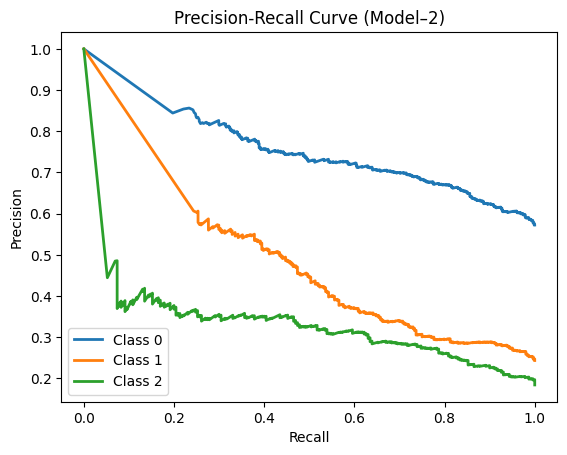

In [449]:
# 2) Precision-Recall Curves for Model–2
y_test_stance_bin = label_binarize(y_test_stance, classes=np.unique(y_test_stance))
n_classes_stance = y_test_stance_bin.shape[1]

stance_scores = model_stance.predict([X_test_seq, test_preds_target_onehot])

for i in range(n_classes_stance):
    precision, recall, _ = precision_recall_curve(y_test_stance_bin[:, i], stance_scores[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {i}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Model–2)")
plt.legend(loc="lower left")
plt.show()

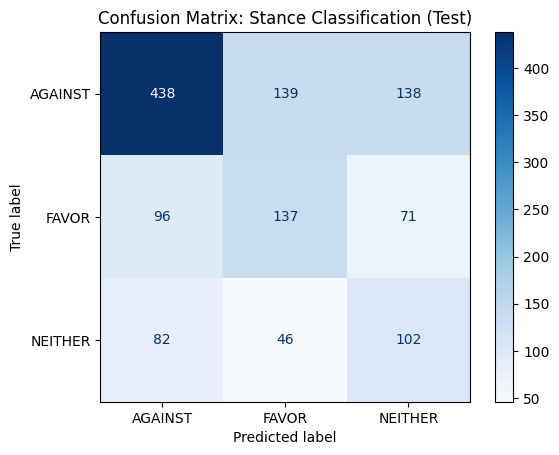

In [387]:
# Confusion matrix hesaplama
conf_matrix = confusion_matrix(y_test_stance, test_preds_stance)

# Confusion matrix'i görselleştirme
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=le_stance.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix: Stance Classification (Test)")
plt.show()

In [450]:
nb_model = MultinomialNB()
# Flatten input for Naive Bayes
X_stance_flat = np.concatenate([X_test_seq, test_preds_target_onehot], axis=1)
nb_model.fit(X_stance_flat, y_test_stance)

# Naive Bayes Predictions
nb_preds_stance = nb_model.predict(X_stance_flat)
print("Naive Bayes F1 Score (Stance classification):", f1_score(y_test_stance, nb_preds_stance, average="weighted"))
print("Naive Bayes Macro Precision:", precision_score(y_test_stance, nb_preds_stance, average="macro"))
print("Naive Bayes Macro Recall:", recall_score(y_test_stance, nb_preds_stance, average="macro"))
print(classification_report(y_test_stance, nb_preds_stance))

Naive Bayes F1 Score (Stance classification): 0.37251255520981064
Naive Bayes Macro Precision: 0.4060209722316461
Naive Bayes Macro Recall: 0.4147077845876473
              precision    recall  f1-score   support

           0       0.68      0.30      0.42       715
           1       0.31      0.28      0.29       304
           2       0.23      0.67      0.34       230

    accuracy                           0.36      1249
   macro avg       0.41      0.41      0.35      1249
weighted avg       0.51      0.36      0.37      1249

